In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
# Turn off warnings and errors due to TF libraries
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import time
import datetime
import csv
from random import shuffle
import tensorflow as tf
# import internal scripts
from tools.tools import *
from test import test
import configs
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import yaml

In [55]:
validation_path=r'/Users/lucascurtin/Desktop/SSH_LOGS/run2/log_validation.csv'
validation_data = pd.read_csv(validation_path)
validation_loss=np.array(validation_data['loss'])
validation_accuracy=np.array(validation_data['accuracy'])

In [56]:
training_path=r'/Users/lucascurtin/Desktop/SSH_LOGS/run2/log_training.csv'
training_data = pd.read_csv(training_path)
training_loss=np.array(training_data['loss'])
training_accuracy=np.array(training_data['accuracy'])

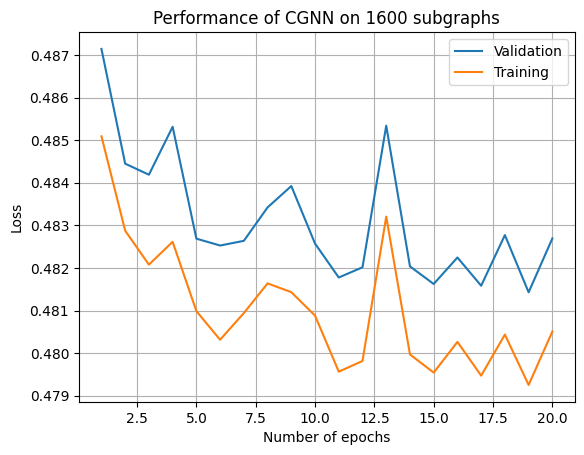

In [57]:
epochs=np.linspace(1,len(validation_loss)-1,len(validation_loss)-1)


#Our model tests on the data before it trains so we have 21 datapoints for 20 epochs, but we remove this value because it makes it hard to see the difference between future points
plt.plot(epochs, validation_loss[1:],label='Validation')
plt.plot(epochs, training_loss[1:],label='Training')
plt.grid()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Performance of CGNN on 1600 subgraphs")
plt.legend(loc='best')
plt.show()

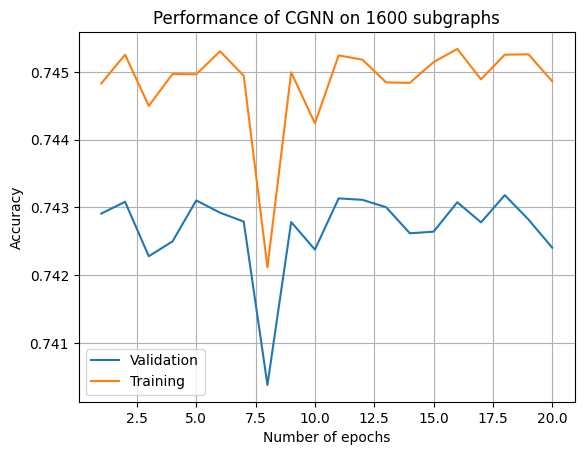

In [58]:
plt.plot(epochs, validation_accuracy[1:],label='Validation')
plt.plot(epochs, training_accuracy[1:],label='Training')
plt.grid()
plt.xlabel("Number of epochs")

plt.ylabel("Accuracy")
plt.title("Performance of CGNN on 1600 subgraphs")
plt.legend(loc='best')
plt.show()